<a href="https://colab.research.google.com/github/huggywuggy1289/data_branch2/blob/main/final_Exam_%EC%86%90%EC%9E%AC%EC%9C%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# 파일 업로드
uploaded = files.upload()

# 업로드된 파일 확인 및 로드
for file_name in uploaded.keys():
    print(f"File {file_name} uploaded successfully")
    data = np.load(file_name)
    print(data.shape)

# 랜덤 시드 설정
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# MNIST 데이터셋 다운로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = MNIST(root='data/', train=True, transform=transform, download=True)
mnist_test = MNIST(root='data/', train=False, transform=transform, download=True)

x_train = mnist_train.data.unsqueeze(1).type(torch.FloatTensor) / 255.0
x_test = mnist_test.data.unsqueeze(1).type(torch.FloatTensor) / 255.0
y_train = mnist_train.targets
y_test = mnist_test.targets


Saving final_exam_손재윤.npy to final_exam_손재윤.npy
File final_exam_손재윤.npy uploaded successfully
(15000, 28, 28)
Using device: cpu
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 57328728.61it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1583845.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13541533.56it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8779045.52it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# 이상 데이터셋 전처리
anomaly_images = []
for img_array in data:
    img = Image.fromarray((img_array * 255).astype(np.uint8)).convert('L')
    img = transform(img)
    anomaly_images.append(img)

anomaly_images = torch.stack(anomaly_images).unsqueeze(1).to(device)

# 이상 데이터셋 인덱스 추적
num_mnist = len(x_train)
num_anomaly = len(anomaly_images)
anomaly_indices = list(range(num_mnist, num_mnist + num_anomaly))

# MNIST 데이터셋과 결합
combined_data = torch.cat((x_train.unsqueeze(1), anomaly_images))
combined_labels = torch.cat((y_train, torch.ones(num_anomaly).to(y_train.device)))

# DataLoader 설정
train_dataset = TensorDataset(combined_data, combined_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [4]:
# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x.view(x.size(0), -1))
        x = self.decoder(x)
        return x.view(x.size(0), 1, 28, 28)

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [5]:
# 학습 과정 시각화를 위한 손실 값 저장 리스트
losses = []

# 모델 학습
num_epochs = 20
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_data, _ in train_loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = loss_function(outputs, batch_data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # 에폭 손실 값 기록
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1, 28, 28])) that is different to the input size (torch.Size([64, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([56, 1, 1, 28, 28])) that is different to the input size (torch.Size([56, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 0.27152375147102636
Epoch 2/20, Loss: 0.2657458594469385
Epoch 3/20, Loss: 0.2655499251400448
Epoch 4/20, Loss: 0.26548069101399124
Epoch 5/20, Loss: 0.26545284417658127
Epoch 6/20, Loss: 0.2654221364306508
Epoch 7/20, Loss: 0.26544973263739524
Epoch 8/20, Loss: 0.2654188454990297
Epoch 9/20, Loss: 0.26541997433827597
Epoch 10/20, Loss: 0.26540875146260845
Epoch 11/20, Loss: 0.2654056759748239
Epoch 12/20, Loss: 0.2653954601608242
Epoch 13/20, Loss: 0.2654062173942759
Epoch 14/20, Loss: 0.26539935724676267
Epoch 15/20, Loss: 0.265397417038018
Epoch 16/20, Loss: 0.2653780652229188
Epoch 17/20, Loss: 0.26537795039370604
Epoch 18/20, Loss: 0.26539812758310666
Epoch 19/20, Loss: 0.26537158379630016
Epoch 20/20, Loss: 0.26536522906133747


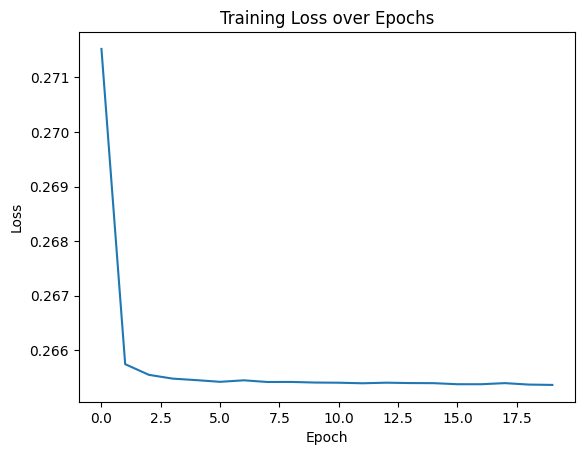

In [6]:
# 손실 값 그래프 시각화
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

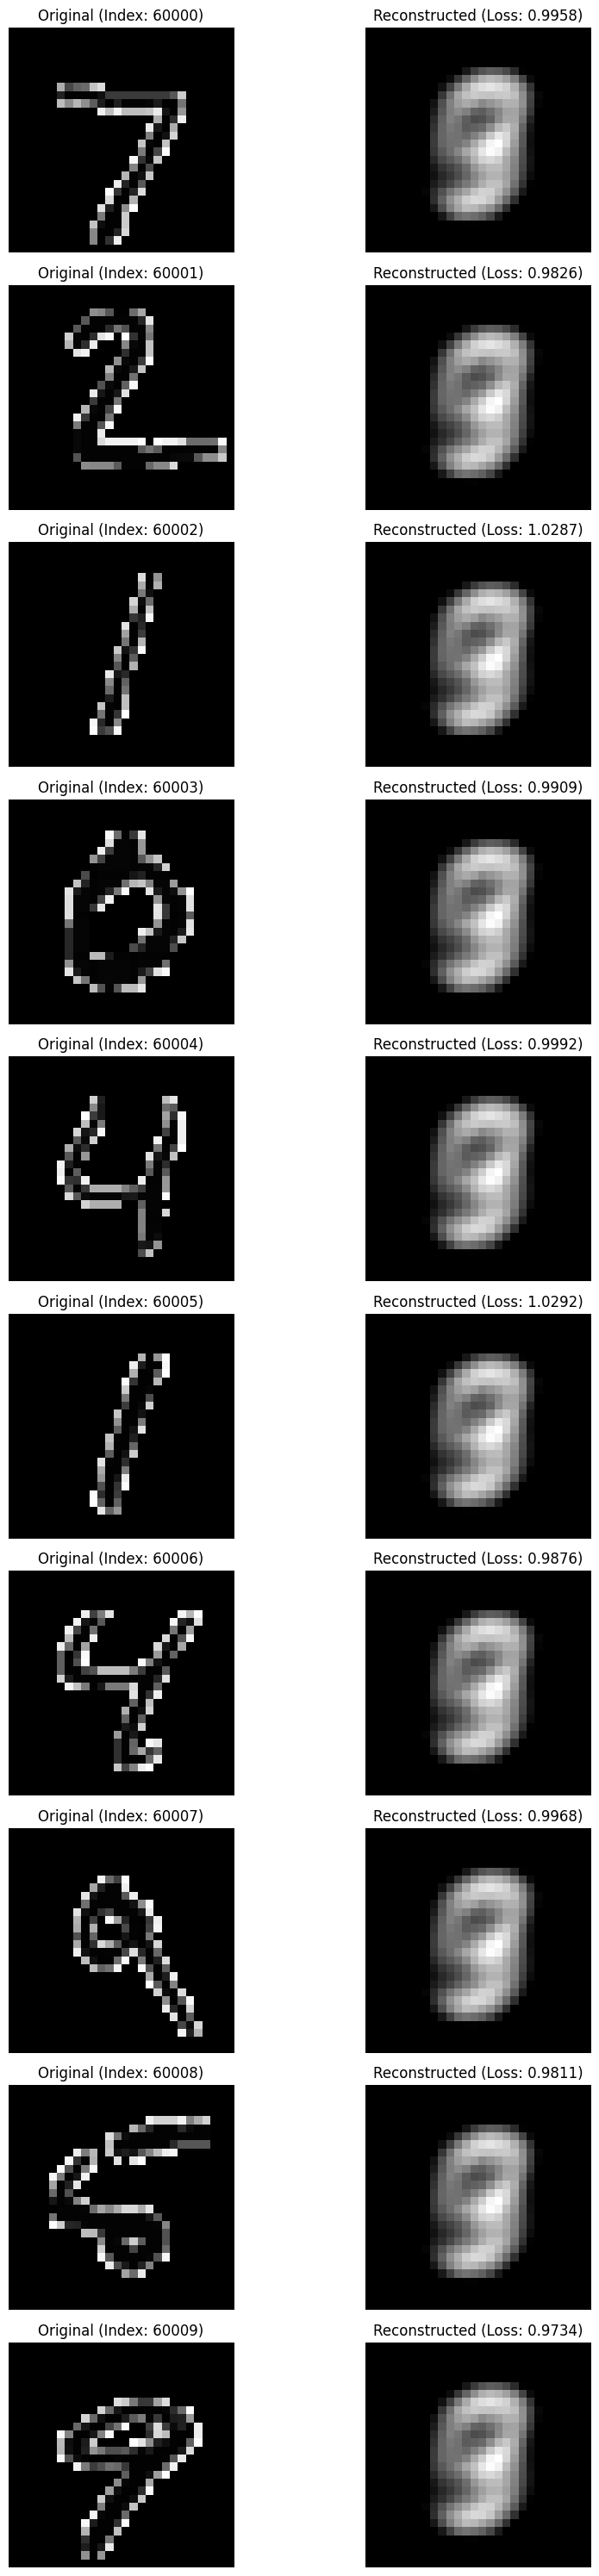

In [8]:
# 이상 데이터 탐지
model.eval()
anomaly_scores = []
for img in anomaly_images:
    img = img.unsqueeze(0)
    reconstructed_img = model(img)
    loss = loss_function(reconstructed_img, img)
    anomaly_scores.append(loss.item())

# 인덱스 값 추출 및 시각적 표현
threshold = 0.05  # 임계값을 낮추어 더 많은 이상 데이터를 탐지하도록 조정
detected_anomalies = [i for i, score in enumerate(anomaly_scores) if score > threshold]

# 탐지된 이상 데이터 시각화
num_display = min(len(detected_anomalies), 10)  # 최대 10개의 이상 데이터 표시
fig, axes = plt.subplots(num_display, 2, figsize=(10, num_display * 3))
for i, idx in enumerate(detected_anomalies[:num_display]):
    original_idx = anomaly_indices[idx]
    original_img = anomaly_images[idx].cpu().squeeze().detach().numpy()
    with torch.no_grad():
        reconstructed_img = model(anomaly_images[idx].unsqueeze(0)).cpu().squeeze().detach().numpy()

    # 원본 이미지
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original (Index: {original_idx})')
    axes[i, 0].axis('off')

    # 재구성 이미지
    axes[i, 1].imshow(reconstructed_img, cmap='gray')
    axes[i, 1].set_title(f'Reconstructed (Loss: {anomaly_scores[idx]:.4f})')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

# 결과 제출
with open('anomaly_indices.txt', 'w') as f:
    for index in detected_anomalies:
        f.write(f"{anomaly_indices[index]}\n")

# 모델 저장
torch.save(model.state_dict(), 'autoencoder_model.pth')


In [9]:
from sklearn.metrics import precision_recall_fscore_support

# 실제 이상 데이터의 레이블 (여기서는 1로 설정, 이상 데이터의 수가 anomaly_images의 길이와 같음)
true_labels = [1] * len(anomaly_images)

# 예측된 레이블 (손실 값이 임계값보다 크면 1로 설정)
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]

# 평가 지표 계산
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [10]:
# 결과 제출
with open('anomaly_indices.txt', 'w') as f:
    for index in detected_anomalies:
        f.write(f"{anomaly_indices[index]}\n")

# 모델 저장
torch.save(model.state_dict(), 'final_exam_손재윤')